In [1]:
!pip install gdown  # Ensure gdown is installed

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1-z7eUmIrYprUr6CQB5FyMlBqx51ESXVa"
output_file = "Footballer_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-z7eUmIrYprUr6CQB5FyMlBqx51ESXVa
From (redirected): https://drive.google.com/uc?id=1-z7eUmIrYprUr6CQB5FyMlBqx51ESXVa&confirm=t&uuid=d5ccedc9-a28e-47c4-ba24-1c4ca286f338
To: /content/Footballer_Datasets.zip
100%|██████████| 119M/119M [00:01<00:00, 78.1MB/s]


'Footballer_Datasets.zip'

In [3]:
import zipfile
z= zipfile.ZipFile('/content/Footballer_Datasets.zip')
z.extractall()

# **Face Detection Library**

In [4]:
!pip install retina-face

# **Import Libraries**

In [1]:
import os
import torch
import random
import torch.nn as nn
from retinaface import RetinaFace
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image, ImageOps

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# **Plot Bar Graph**

In [6]:
images_dir = "Footballer_Datasets/train"
images_dir_footballer = os.listdir(images_dir)
data = []
for filename in images_dir_footballer:
    cls_name = filename.split("_",1)[0]
    data.append(cls_name)

# print(data)

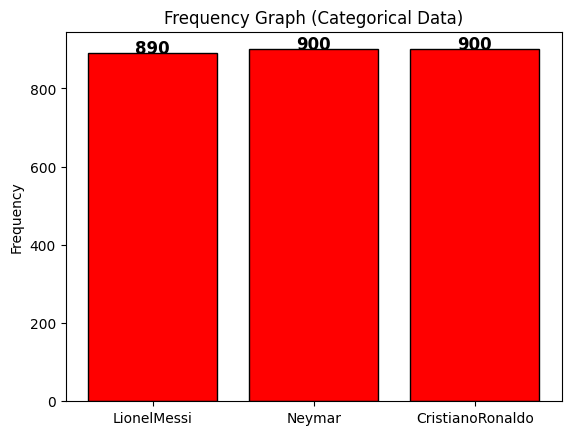

In [7]:
from collections import Counter

# Count occurrences of each category
frequency = Counter(data)

# Extract labels and their frequencies
labels, counts = zip(*frequency.items())

# Plot bar chart
plt.bar(labels, counts, color='red', edgecolor='black')

# Add frequency labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', fontsize=12, fontweight='bold')

# Remove x-axis numerical ticks (optional)
plt.xticks(range(len(labels)), labels)

# Labels and title
plt.ylabel("Frequency")
plt.title("Frequency Graph (Categorical Data)")

# Show plot
plt.show()


# **Display the images**

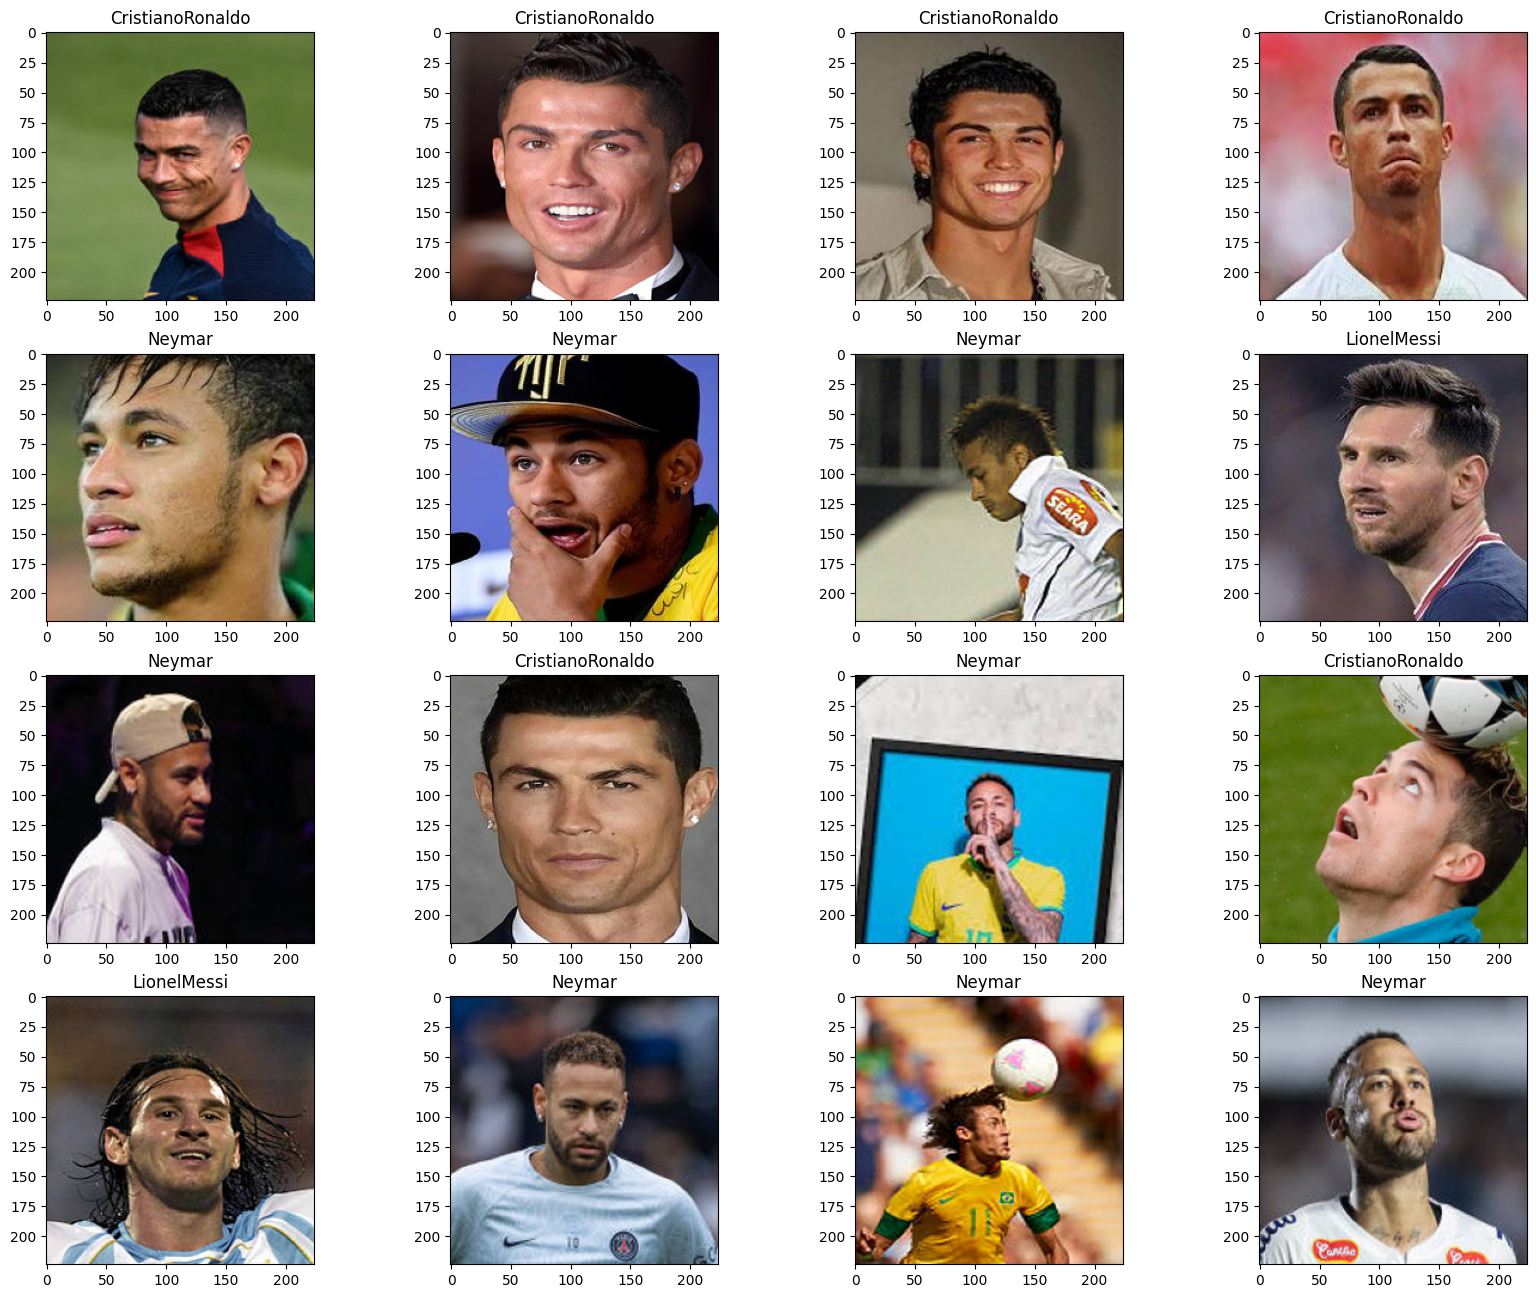

In [8]:
images_dir = "Footballer_Datasets/train"
images_dir_footballer = os.listdir(images_dir)

fig,ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.ravel()

for i in range(16):
    images_name = random.choice(images_dir_footballer)
    img_path = os.path.join(images_dir,images_name)
    img = Image.open(img_path)
    cls_name = images_name.split("_",1)[0]
    ax[i].imshow(img)
    ax[i].set_title(cls_name)

plt.show()

# **Transfroms**

In [9]:
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure it's grayscale
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(15),  # Rotate up to ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Small shifts & shearing
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Add slight blur for robustness
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# **Create the datasets class**

In [10]:
class data():
    def __init__(self, dir, dir_files,transforms=None):
        self.dir = dir
        self.dir_files = dir_files
        self.transforms = transforms

    def __len__(self):
        return len(self.dir_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir,self.dir_files[idx])
        img = Image.open(img_path)
        img = ImageOps.grayscale(img)

        cls_name = self.dir_files[idx].split("_",1)[0]
        if cls_name == 'CristianoRonaldo':
            label = 0
        elif cls_name == 'LionelMessi':
            label = 1
        else:
            label = 2

        if self.transforms is not None:
            img = self.transforms(img)

        return (img, label)


# **Create train oject**

In [11]:
dir_files = os.listdir(images_dir)
train = data(images_dir, dir_files, transformation)

# **Create the datsets**

In [12]:
import torch
from torch.utils.data import DataLoader, random_split

# Assume `train` is your dataset (not a DataLoader)
dataset_size = len(train)  # Get dataset size
print(dataset_size)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(train, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


2690
Training size: 2152
Validation size: 538


# **Get the shape**

In [13]:
print(train.__getitem__(0)[0].shape)

torch.Size([1, 224, 224])


In [14]:
print(len(train_dataset))

2152


# **Plot the images**

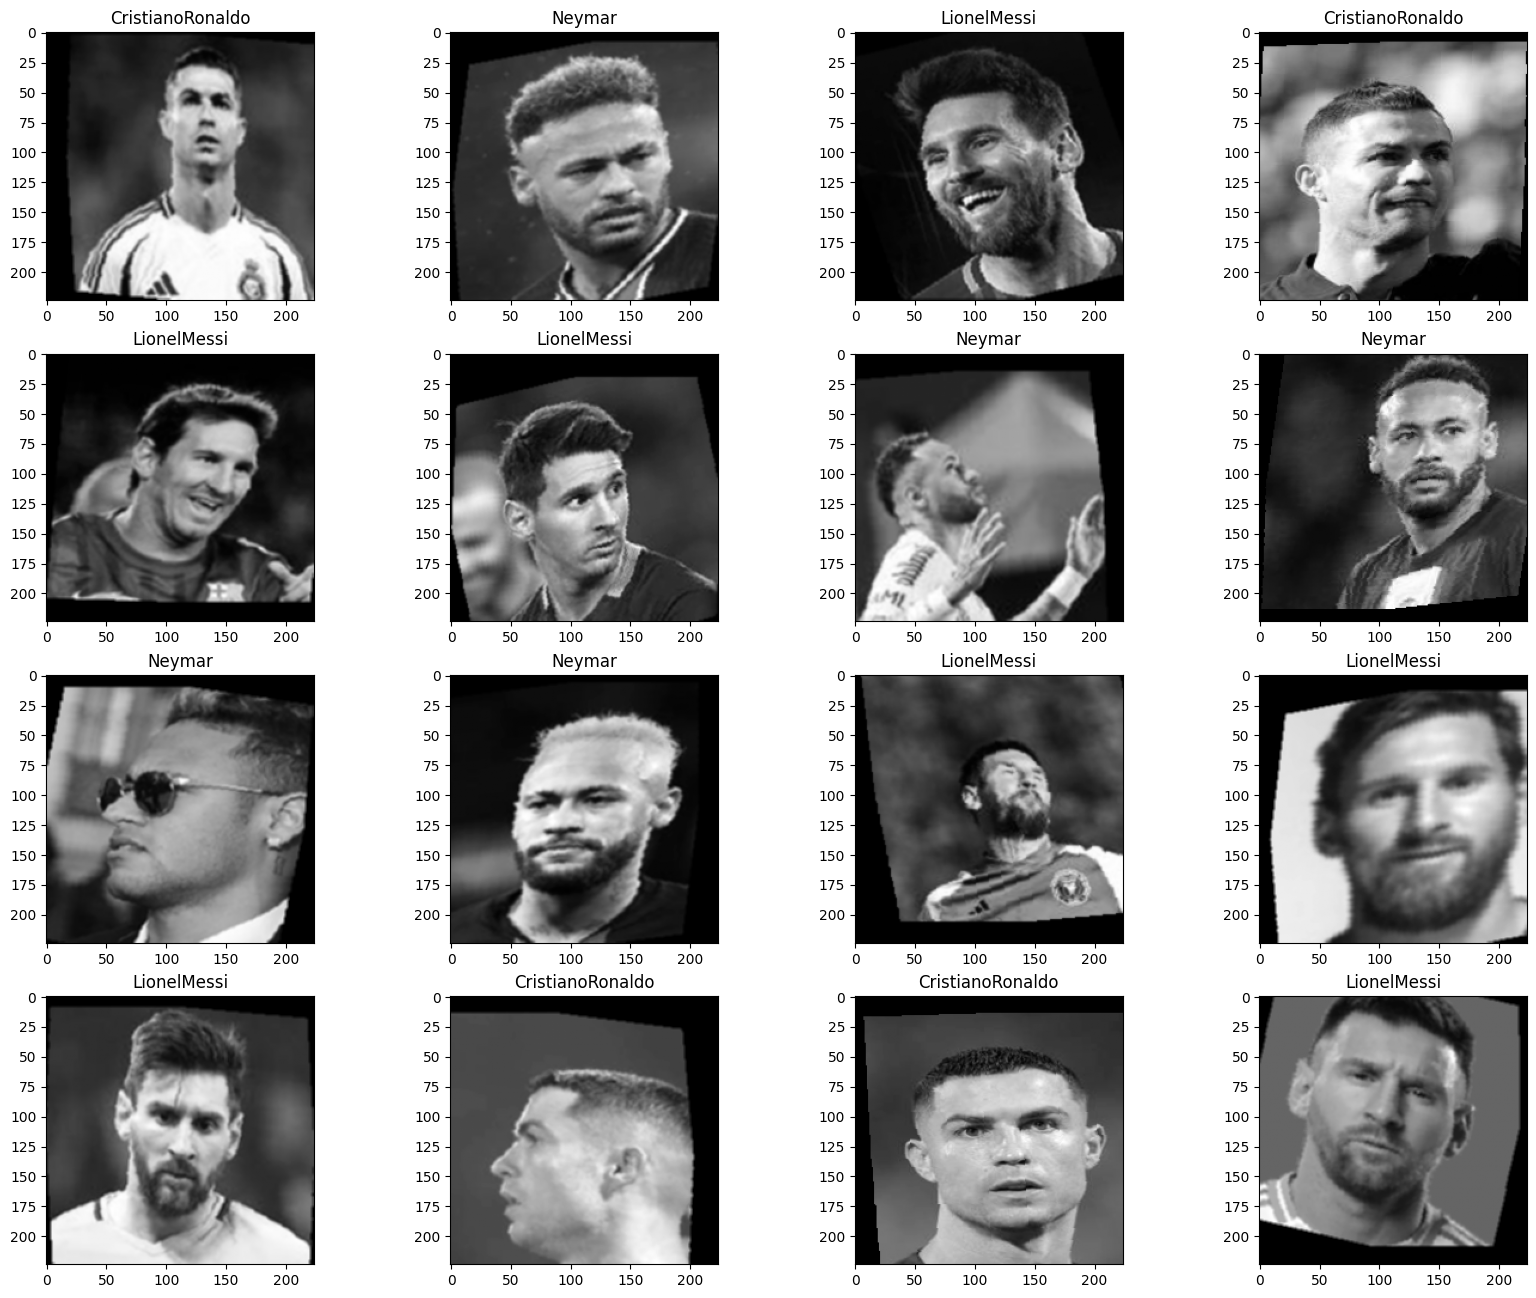

In [15]:
samples,labels = next(iter(train_dataloader))

fig, axes = plt.subplots(4,4,figsize=(20,16))
axes = axes.ravel()

class_names = {0:'CristianoRonaldo',1:'LionelMessi',2:'Neymar'}

for i in range(16):
    axes[i].imshow(samples[i].permute(1,2,0),cmap='gray')  ## (C,H,W) to (H,W,C)
    # print(labels[i])
    axes[i].set_title(class_names[labels[i].item()])


# **Create the CNN model**

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.batch1 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batch2 = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch3 = nn.BatchNorm2d(num_features=64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch4 = nn.BatchNorm2d(num_features=128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3)
        self.batch5 = nn.BatchNorm2d(num_features=512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=5*5*512, out_features=1024)
        self.fc1_batch = nn.BatchNorm1d(num_features=1024)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc2_batch = nn.BatchNorm1d(num_features=256)

        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc3_batch = nn.BatchNorm1d(num_features=128)

        self.fc4 = nn.Linear(in_features=128, out_features=3)

        self.softmax = nn.Softmax(dim=1)


    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = self.softmax(x)

        return x

model = CNN().to(device)

# **Get the model summary**

In [17]:
from torchsummary import summary
summary(model, (1,224,224)) # (C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
       BatchNorm2d-2         [-1, 16, 222, 222]              32
         MaxPool2d-3         [-1, 16, 111, 111]               0
            Conv2d-4         [-1, 32, 109, 109]           4,640
       BatchNorm2d-5         [-1, 32, 109, 109]              64
         MaxPool2d-6           [-1, 32, 54, 54]               0
            Conv2d-7           [-1, 64, 52, 52]          18,496
       BatchNorm2d-8           [-1, 64, 52, 52]             128
         MaxPool2d-9           [-1, 64, 26, 26]               0
           Conv2d-10          [-1, 128, 24, 24]          73,856
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 512, 10, 10]         590,336
      BatchNorm2d-14          [-1, 512,

# **Define optimizers**

In [18]:
criterian = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# **Define model training**

In [19]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []


best_val_loss = float('inf')  # Initialize with a high value

# Directory to save models
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)


for epoch in range(epochs):
    model.train()
    correct = 0
    train_running_loss = 0.0

    for data,labels in train_dataloader:
        data,labels = data.to(device), labels.to(device)
        optimizer.zero_grad() ## convert the gradient values into zero for each batch
        output = model(data)
        loss = criterian(output, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        _,pred = torch.max(output,1)

        correct += (pred == labels).sum().item()

    epoch_train_loss = train_running_loss / len(train_dataloader)
    epoch_train_accuracy = (100 * correct) / len(train_dataset)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    print(f'Epoch: {epoch+1} Training Loss: {epoch_train_loss} Training Accuracy: {epoch_train_accuracy}')

    with torch.no_grad():
        model.eval()
        correct = 0
        val_running_loss = 0.0
        for val_data, val_labels in val_dataloader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_output = model(val_data)
            val_loss_value = criterian(val_output, val_labels)

            val_running_loss += val_loss_value.item()
            _,val_pred = torch.max(val_output,1)
            correct += (val_pred == val_labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_dataloader)
        epoch_val_accuracy = (100 * correct) / len(val_dataset)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        print(f'Epoch: {epoch+1} Validation Loss: {epoch_val_loss} Validation Accuracy: {epoch_val_accuracy}')


        # ModelCheckpoint: Save best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pth")
            torch.save(model, checkpoint_path)
            print(f"🔥 Best model saved at {checkpoint_path} with Validation Loss: {epoch_val_loss:.4f}")


    # Update learning rate
    scheduler.step()
    print(f"🔄 Updated Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")

    print("\n")

Epoch: 1 Training Loss: 0.9938206979457069 Training Accuracy: 52.5092936802974
Epoch: 1 Validation Loss: 0.9142064066494212 Validation Accuracy: 61.33828996282528
🔥 Best model saved at checkpoints/best_model.pth with Validation Loss: 0.9142
🔄 Updated Learning Rate: 0.000976



Epoch: 2 Training Loss: 0.91164491194136 Training Accuracy: 62.96468401486989
Epoch: 2 Validation Loss: 0.9496568125836989 Validation Accuracy: 57.62081784386617
🔄 Updated Learning Rate: 0.000905



Epoch: 3 Training Loss: 0.8537222383653417 Training Accuracy: 69.14498141263941
Epoch: 3 Validation Loss: 0.9496469182126662 Validation Accuracy: 59.10780669144982
🔄 Updated Learning Rate: 0.000794



Epoch: 4 Training Loss: 0.8607531479176354 Training Accuracy: 67.19330855018588
Epoch: 4 Validation Loss: 0.8307751802837148 Validation Accuracy: 71.56133828996282
🔥 Best model saved at checkpoints/best_model.pth with Validation Loss: 0.8308
🔄 Updated Learning Rate: 0.000655



Epoch: 5 Training Loss: 0.8074414046371684 

# **Plot the graph**

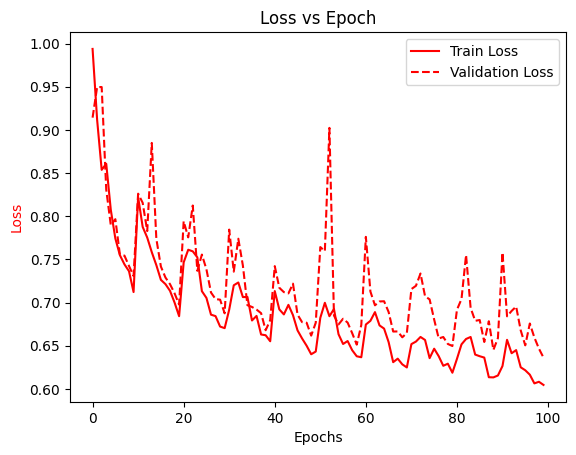

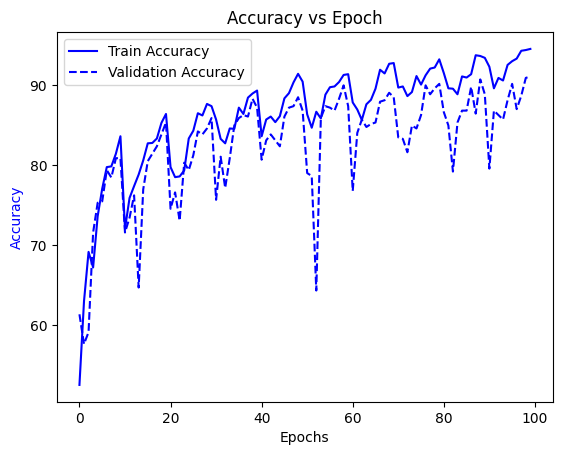

In [20]:
epoch_log = [*range(epochs)]

fig,ax1 = plt.subplots()
ax1.plot(epoch_log,train_loss,'r-',label = 'Train Loss')
ax1.plot(epoch_log,val_loss,'r--',label = 'Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='r')
ax1.set_title('Loss vs Epoch')
ax1.legend()
plt.show()

print("\n")

fig,ax2 = plt.subplots()
ax2.plot(epoch_log,train_accuracy,'b-',label = 'Train Accuracy')
ax2.plot(epoch_log,val_accuracy,'b--',label = 'Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy',color='b')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
plt.show()

# **Load the model**

In [21]:
# Initialize the model before loading weights
# model = CNN()  # Ensure MyModel is defined
# model.load_state_dict(torch.load("checkpoints/best_model.pth"))  # Load state_dict into the model
model = torch.load("checkpoints/best_model.pth")
model.to(device)  # Move model to GPU or CPU
model.eval()  # Set to evaluation mode


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 512, kernel_siz

# **Plot the images**

In [2]:
def detect_and_crop_face(image_path):
    """Detects a face in an image, crops it, and resizes it to 224x224."""
    image = Image.open(image_path)
    faces = RetinaFace.detect_faces(image_path)

    if len(faces) >= 2:
        print(f"Multiple faces detected in {image_path}, skipping...")
        return None
    elif len(faces) == 0:
        print(f"No face detected in {image_path}, skipping...")
        return None

    # print(faces)
    key = list(faces.keys())[0]
    face = faces[key]
    x1, y1, x2, y2 = face["facial_area"]

    # Expand bounding box
    expansion = 60
    x1 = max(0, x1 - expansion)
    y1 = max(0, y1 - expansion)
    x2 = min(image.size[1], x2 + expansion)
    y2 = min(image.size[0], y2 + expansion)

    # Crop and resize face
    face_crop = image.crop((x1, y1, x2, y2))
    face_resized = face_crop.resize((224, 224))

    return face_resized

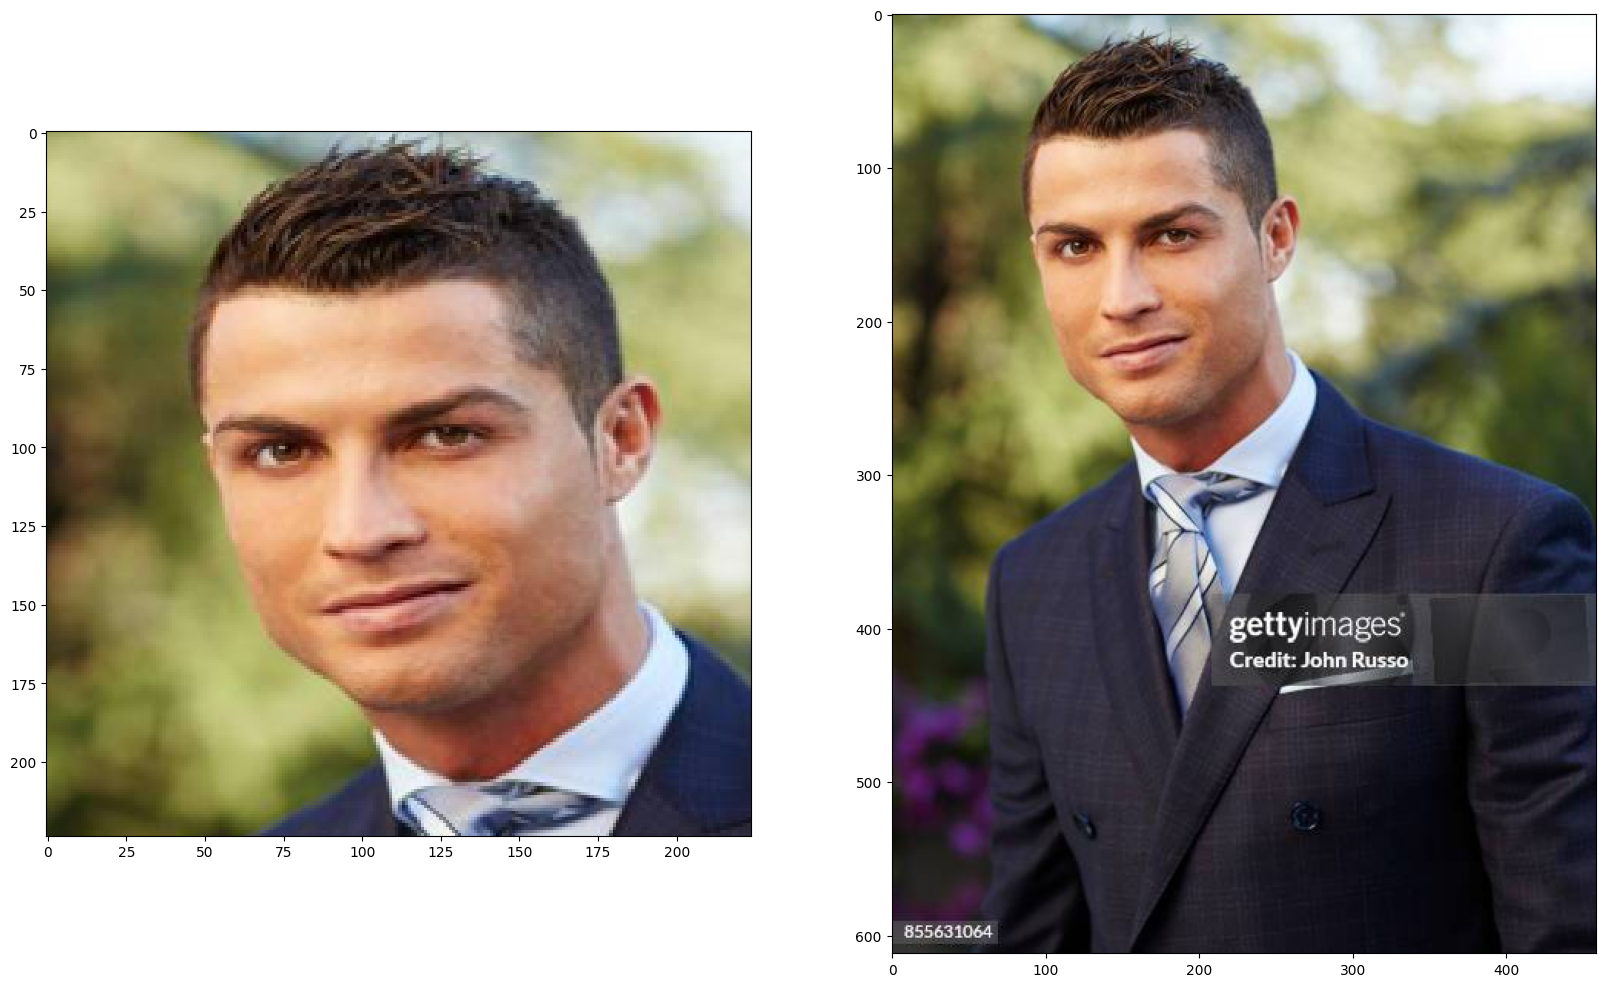

In [ ]:
import random

fig,axes = plt.subplots(1,2,figsize=(20,22))
axes = axes.ravel()

test_dir = '../Footballer_Datasets/test'
test_filenames = os.listdir(test_dir)
img_path = os.path.join(test_dir,random.choice(test_filenames))
preprocessed_img = detect_and_crop_face(img_path)
axes[0].imshow(preprocessed_img)
image = Image.open(img_path)
axes[1].imshow(image)
plt.show()


25-02-22 09:50:24 - Directory /root/.deepface created
25-02-22 09:50:24 - Directory /root/.deepface/weights created
25-02-22 09:50:24 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 116MB/s]


Multiple faces detected in Footballer_Datasets/test/QQ3miLoIfwGI.png, skipping...
No face detected in Footballer_Datasets/test/X0QLUtlJsbNl.png, skipping...


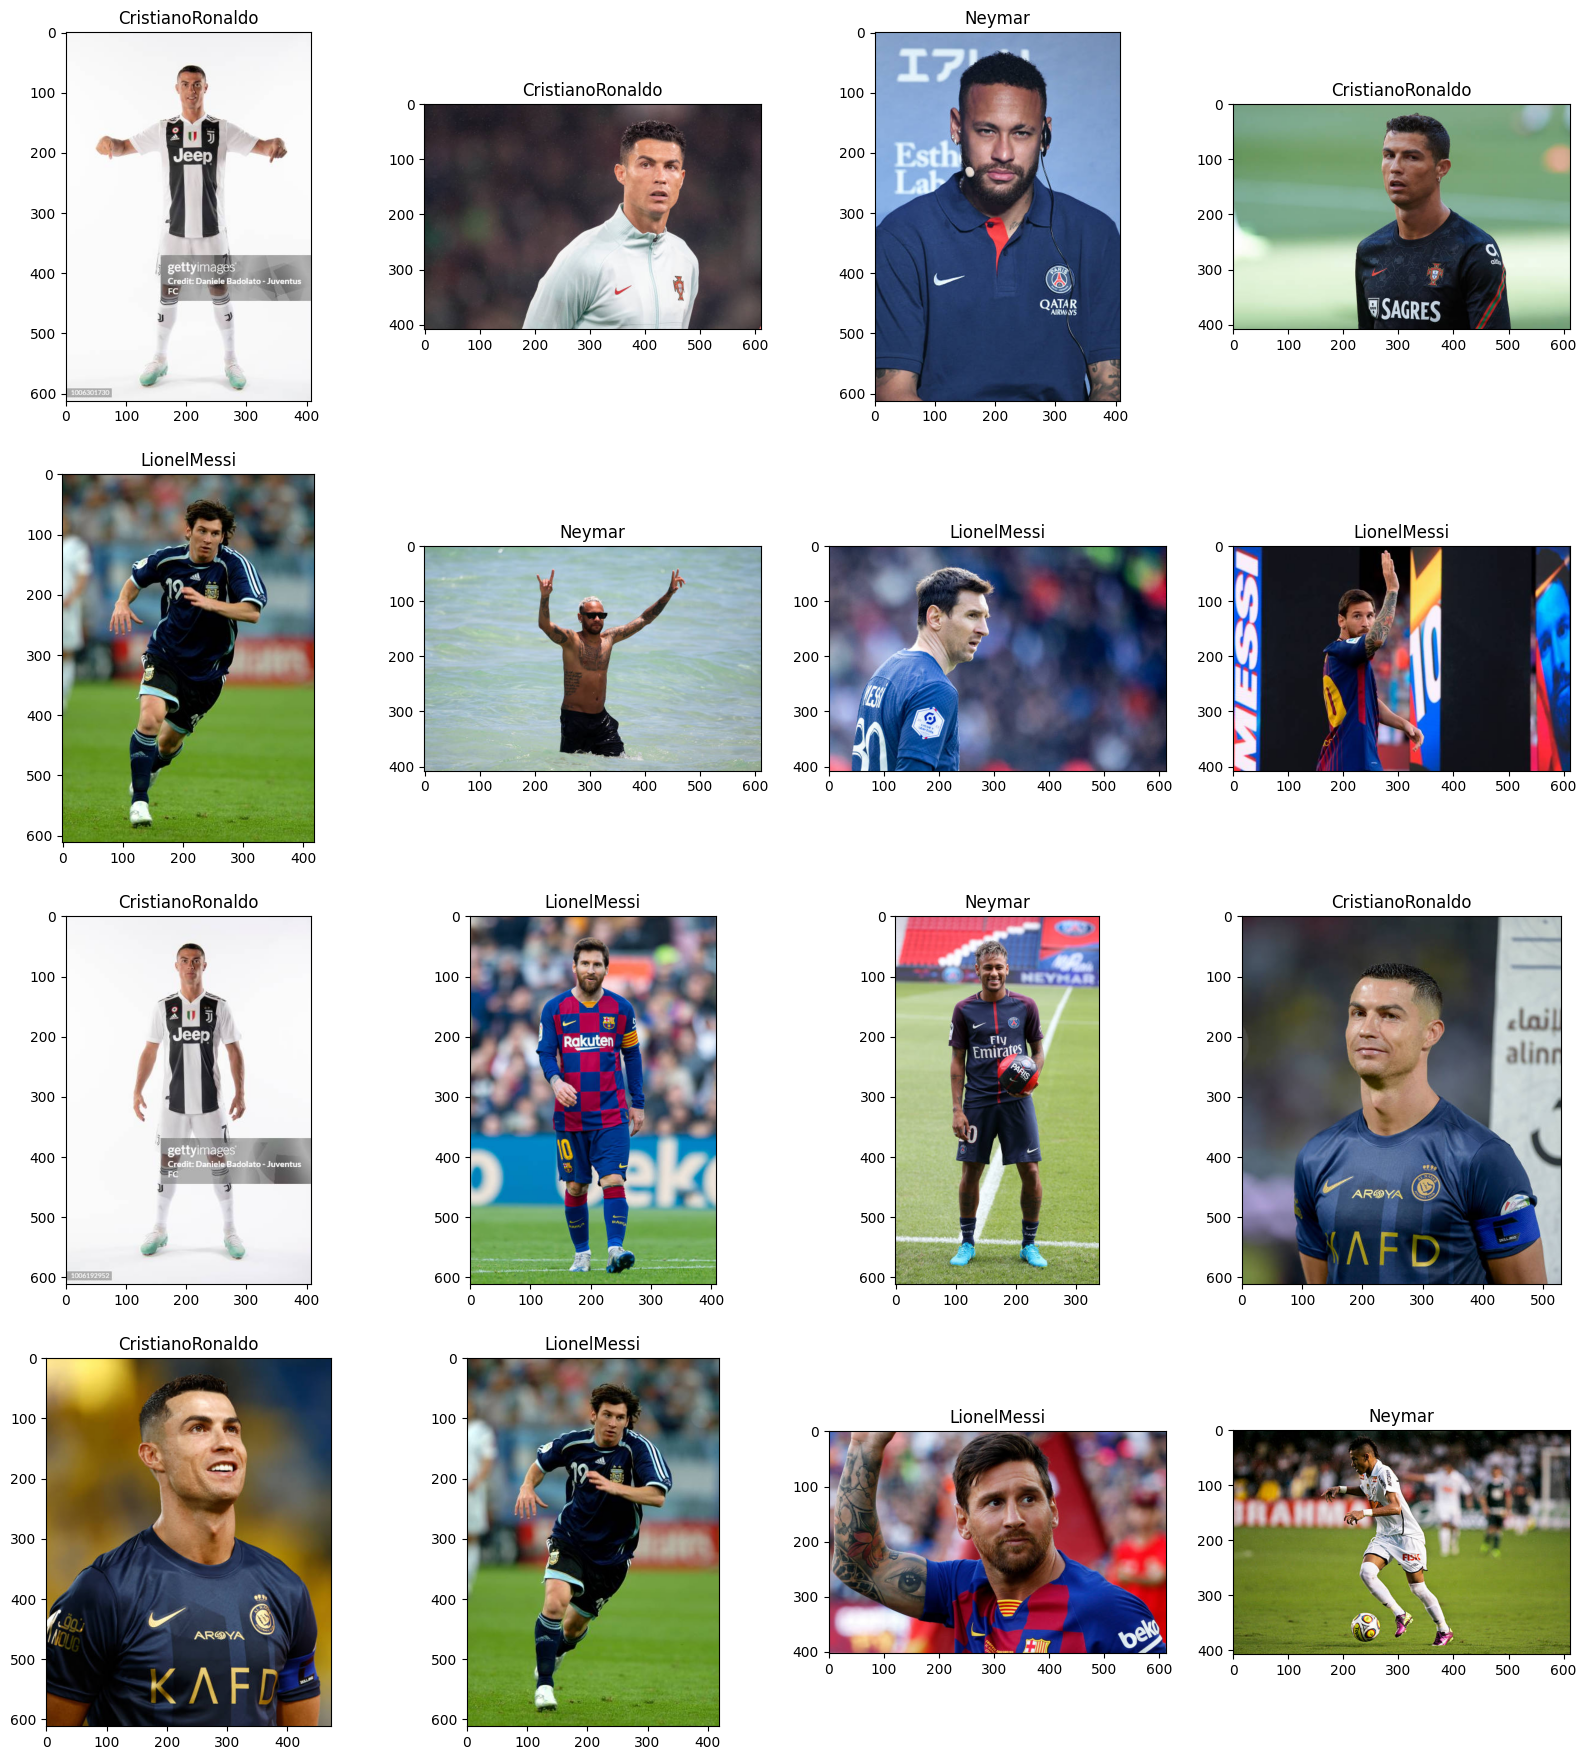

In [23]:
import random

test_dir = 'Footballer_Datasets/test'
test_filenames = os.listdir(test_dir)

images = []
def preprocessing(image):
    img = transformation(image) ##  (c,h,w) required == (b,c,h,w) ==> (1,3,60,60)
    img = img.unsqueeze(0)
    return img

fig, axes = plt.subplots(4,4,figsize=(20,22))
axes = axes.ravel()

class_names = {0:'CristianoRonaldo', 1:'LionelMessi', 2:'Neymar'}

i = 0
while i<16:
    img_path = os.path.join(test_dir,random.choice(test_filenames))
    preprocessed_img = detect_and_crop_face(img_path)
    if preprocessed_img is None:
      continue
    preprocessed_img = ImageOps.grayscale(preprocessed_img)
    preprocessed_img = preprocessing(preprocessed_img)
    preprocessed_img = preprocessed_img.to(device)

    output = model(preprocessed_img)
    pred = torch.argmax(output).item()
    label = class_names[pred]

    image = Image.open(img_path)

    axes[i].imshow(image)
    axes[i].set_title(label)
    i += 1

plt.show()


In [24]:
!pip show torch

Name: torch
Version: 2.5.1+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


In [25]:
!pip show torchvision

Name: torchvision
Version: 0.20.1+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [26]:
!pip show torchaudio


Name: torchaudio
Version: 2.5.1+cu124
Summary: An audio package for PyTorch
Home-page: https://github.com/pytorch/audio
Author: Soumith Chintala, David Pollack, Sean Naren, Peter Goldsborough, Moto Hira, Caroline Chen, Jeff Hwang, Zhaoheng Ni, Xiaohui Zhang
Author-email: soumith@pytorch.org
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: torch
Required-by: 
